# Starter Notebook

Install and import required libraries

In [1]:
# !pip install transformers datasets evaluate accelerate peft trl bitsandbytes
# !pip install nvidia-ml-py3

In [2]:
# !pip install pandas

In [3]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

/home/ns6287/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load Tokenizer and Preprocess Data

In [5]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [6]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [7]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [8]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

In [9]:
print("Eval Dataset Number of Entries: ", eval_dataset.num_rows)
print("Train Dataset Number of Entries: ", train_dataset.num_rows)

Eval Dataset Number of Entries:  640
Train Dataset Number of Entries:  119360


## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [10]:
# PEFT Config
peft_config = LoraConfig(
    r=8, # Rank in LoRA
    lora_alpha=16, # controls how strongly the adaptation influences the original weights.
    lora_dropout=0.1,
    bias = 'none',
    target_modules = ['query', 'value'],
    task_type="SEQ_CLS",
)

In [11]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [12]:
print("Trainable parameters:")
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name)

Trainable parameters:
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.query.lora_B.default.weight
base_model.model.roberta.encoder.layer.2.attention.self.value.lora_A.default.weight
base_model.model.roberta.encoder.layer.2.attention.sel

In [13]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


## Training Setup

In [14]:
# !pip install scikit-learn

In [15]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [16]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='steps',
    logging_steps=200,
    learning_rate=2e-4,
    num_train_epochs=5,
    dataloader_num_workers=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    weight_decay=0.01,
    gradient_checkpointing=True,
    warmup_ratio=0.1,
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

### Start Training

In [17]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
200,1.386300,1.378667,0.384375
400,1.370000,1.354068,0.526563
600,1.336200,1.318969,0.485938
800,1.286400,1.256676,0.776563
1000,1.204500,1.166451,0.821875
1200,1.113600,1.049844,0.831250
1400,0.990500,0.895600,0.867188
1600,0.850900,0.740701,0.873437
1800,0.722900,0.625547,0.859375
2000,0.631300,0.533334,0.870313


/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/ns6287/.local/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_g

KeyboardInterrupt: 

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [18]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [19]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [20]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [21]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:03<00:00, 21.63it/s]

Evaluation Metric: {'accuracy': 0.89375}


### Run Inference on unlabelled dataset

In [22]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map: 100%|██████████| 8000/8000 [00:05<00:00, 1386.03 examples/s]


Dataset({
    features: ['text'],
    num_rows: 8000
})

In [23]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:35<00:00, 28.51it/s]


Inference complete. Predictions saved to inference_output.csv


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [25]:
def show_confusion_matrix(model, dataset, tokenizer, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    true_labels = []
    pred_labels = []

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

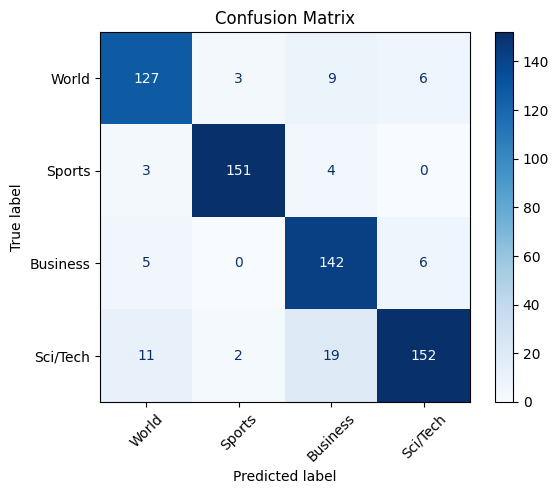

In [27]:
show_confusion_matrix(peft_model, eval_dataset, tokenizer)